# Predviđanje uspjeha studenata
### Analiza seta, izrada te uporaba modela baziranog na podatcima o studentima
Tomislav Kućar, kucar.tomislav@gmail.com
## Priprema okruženja
Potreban nam je IPython (Jupyter), te moduli `pandas`, `numpy`, `matplotlib`, `scipy`, `seaborn`

In [2]:
%matplotlib inline

import re
import traceback
import string
import pandas as pd
import pandas.core.algorithms as algos
from pandas import Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from scipy.stats import zscore
import scipy.stats.stats as stats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import joblib

## Kontrola kvalitete i statistička analiza uzorka podataka

Raditi ćemo na datasetu student-por.csv (Portuguese language course) posto on
ima 650 stavki dok student-mat.csv ima samo 396, od čega je 382 studenata
zajedničko između setova podataka. Bitno je znati kako studenti u datasetu
pohađaju 9 godina osnovnog školovanja, nakon čega slijedi 3 godine
sekundarnog obrazovanja. Ocjene za tri godine sekundarnog obrazovanja označene su
kao G1, G2 i G3.

Za početak ćemo učitati podatke iz datoteke i prikazati prvih 3 zapisa za studente svake škole,
"GP" - Gabriel Pereira i "MS" - Mousinho da Silveira.

In [3]:
path = 'https://frainfreeze.github.io/studying/university/12032-DecisionMakingSuportSystems/project/dataset/student-por.csv'
df = pd.read_csv(path, sep=';')
df.groupby('school').head(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
423,MS,F,16,U,GT3,T,1,3,at_home,other,...,4,3,3,1,3,5,11,10,11,11
424,MS,F,16,R,GT3,T,2,2,other,other,...,4,4,4,1,1,5,0,12,12,12
425,MS,F,15,R,GT3,T,1,1,at_home,services,...,4,1,3,1,1,2,6,10,10,10


Nadalje moramo provjeriti imamo li nedostajućih vrijednosti.

In [4]:
df.isnull().values.any()

False

Provjerom otkrivamo kako nema nedostajućih vrijednosti.
Dataset je potpun. U slučaju da su postojale nedostajuće
vrijednosti rekodirali bi ih, npr .null. -> "missing", posto
nam nedostajuće vrijednosti također mogu sluziti kao podatak,
za sto bi iskoristili bi jednu od prikladnih metoda za
nedostajuće vrijednosti, no kako nemamo nedostajućih vrijednosti
u datasetu nastavljamo s analizom.

Da bismo bolje upoznali obilježja varijabli i općenito se bolje 
upoznali sa setom podataka računamo temeljna statistička obilježja
te iscrtavamo histograme za podatke:

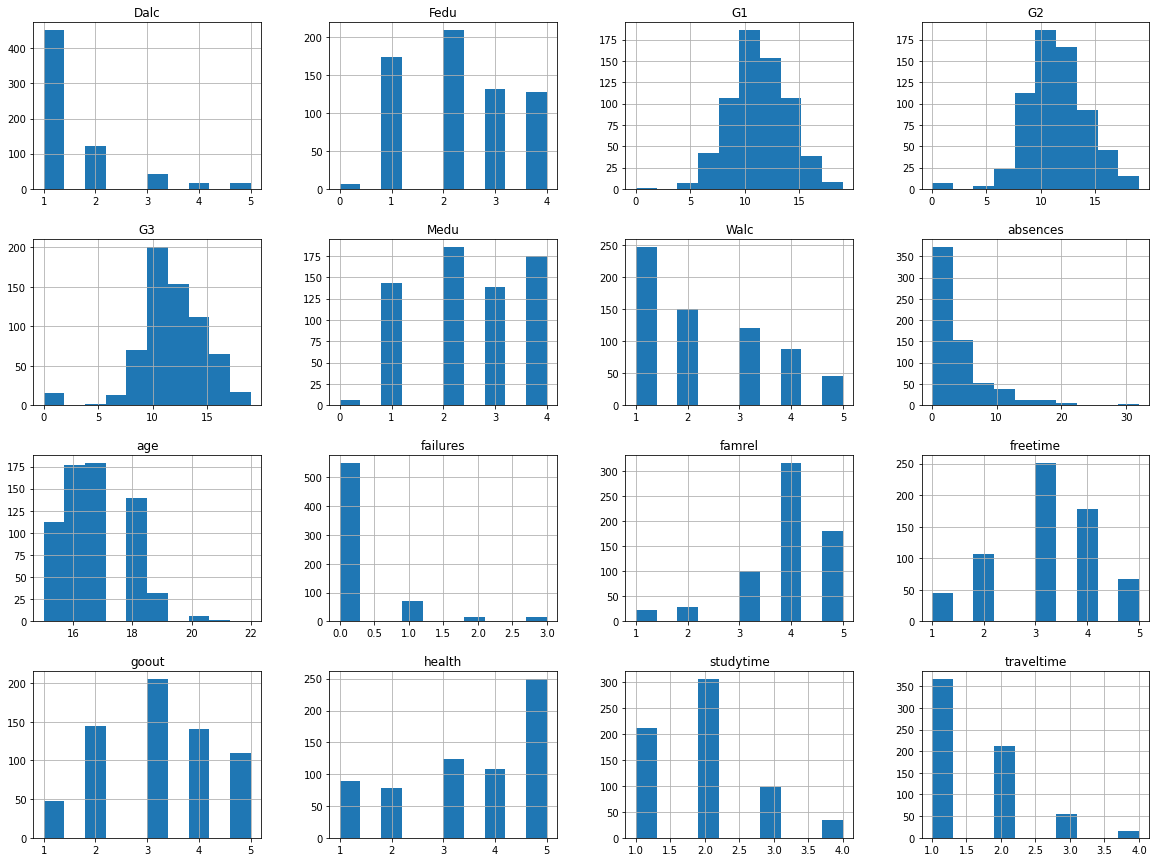

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


In [5]:
df.hist(figsize=(20, 15))
plt.show()
df.describe()

Vidimo kako se radi o kompaktnoj distribuciji (jako niske standardne devijacije, 
i malena razlika između min i max).

Dalc predstavlja unos alkohola tijekom radnog tjedna (1 jako malo, 5 jako puno),
vidimo kako jako malen studenata pije veće količine alkohola tijekom tjedna.
Vikiendom se broj studenata koji pije veću količinu alkohola znatno povećava
(Walc, 1 jako malo, 5 jako puno.)

Fedu i Medu predstavljaju očevu i majčinu razinu edukacije, koje su u ovom setu
podataka slične, uz nešto veći stupanj vise edukacije očeva.

G1, G2, G3 su ocjene iz portugalskog na skali od 0 do 20, gdje je G1 first 
period grade, G2 second period grade i G3 final grade.

Polje absences predstavlja broj izostanaka iz škole (0 do 93)

Failures je broj prošlih padova predmeta (n ako je 1 <= n < 3, inače 4)

famrel, freetime, goout i health predstavljaju odnose s obitelji, količinu 
slobodnog vremena nakon škole, frekvenciju izlazaka s prijateljima te trenutno 
stanje zdravlja, gdje je 1 jako nisko, 5 jako visoko.

Studytime i traveltime predstavljaju vrijeme potrošeno na učenje te na putovanje 
do škole, gdje je za study time imamo 1 - <2 sata, 2 - 2 do 5 sati, 3 - 5 do 10
sati, i 4 - >10 sati učenja tjedno, te za traveltime 1 - <15 min., 2 - 15 do 30 min., 
3 - 30 min. do 1 sat, i 4 - >1 sata putovanja.

Zanima nas i zaobljenost te simetričnost distribucije:

In [15]:
df.kurt()

age           0.071509
Medu         -1.260619
Fedu         -1.109241
traveltime    1.108865
studytime     0.037846
failures      9.824409
famrel        1.348973
freetime     -0.396959
goout        -0.865454
Dalc          4.349297
Walc         -0.770689
health       -1.121175
absences      5.781078
G1            0.036638
G2            1.662465
G3            2.712204
dtype: float64

In [16]:
df.skew()

age           0.416795
Medu         -0.029950
Fedu          0.215343
traveltime    1.247648
studytime     0.699619
failures      3.092699
famrel       -1.105934
freetime     -0.181277
goout        -0.008580
Dalc          2.141913
Walc          0.635904
health       -0.500656
absences      2.020694
G1           -0.002774
G2           -0.360283
G3           -0.912909
dtype: float64

Budući da želimo prepoznati studente koji će položiti završni ispit kreirat ćemo
ciljnu varijablu koja ima vrijednost `1` u svakom retku koji se odnosi na ocjene
završne godine (G3) s bodovima većim od 10 i vrijednost `0` u svim ostalim recima.

In [17]:
df['ciljna'] = np.where(df['G3'] >=10, 1, 0)
df.groupby('ciljna').first()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
ciljna,,,,,,,,,,,,,,,,,,,,,
0,GP,M,17,U,GT3,T,3,2,services,services,...,5,5,5,2,4,5,2,8,8,7
1,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11


Nadalje želimo izračunati i z vrijednosti, primjer za `age`:

In [18]:
((df['age']-np.mean(df['age']))/np.std(df['age'])).head(5)

0    1.031695
1    0.210137
2   -1.432980
3   -1.432980
4   -0.611422
Name: age, dtype: float64

Z vrijednosti za sve brojčane stupce možemo izračunati i pomoću zscore
funkcije iz scipy paketa tako da ćemo koristiti tu funkciju za normiranje
podataka:

In [19]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_norm = df[numeric_cols].apply(zscore)
df_norm.head(5)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,ciljna
0,1.031695,1.310216,1.540715,0.576718,0.083653,-0.374305,0.072606,-0.171647,0.693785,-0.543555,-0.997695,-0.371042,0.073433,-4.155470,-0.195820,-0.280658,0.42679
1,0.210137,-1.336039,-1.188832,-0.760032,0.083653,-0.374305,1.119748,-0.171647,-0.157380,-0.543555,-0.997695,-0.371042,-0.357863,-0.874570,-0.195820,-0.280658,0.42679
2,-1.432980,-1.336039,-1.188832,-0.760032,0.083653,-0.374305,0.072606,-0.171647,-1.008546,0.538553,0.560678,-0.371042,0.504730,0.219064,0.491137,0.029116,0.42679
3,-1.432980,1.310216,-0.278983,-0.760032,1.290114,-0.374305,-0.974536,-1.123771,-1.008546,-0.543555,-0.997695,1.012903,-0.789159,0.948153,0.834615,0.648663,0.42679
4,-0.611422,0.428131,0.630866,-0.760032,0.083653,-0.374305,0.072606,-0.171647,-1.008546,-0.543555,-0.218508,1.012903,-0.789159,-0.145481,0.491137,0.338889,0.42679


Vrijednosti ćemo grupirati kategorizirane u razrede <-3 , (-3 do 3), >3

In [22]:
limit = -3.402823*10**38
limit_up = 3.402823*10**38
df2 = df_norm.copy()
df2['bin'] = pd.cut(df2['age'], [limit, -3, 3, limit_up], labels=['<-3', '-3 to 3', '>3'])
df2.groupby('bin').head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,ciljna,bin
0,1.031695,1.310216,1.540715,0.576718,0.083653,-0.374305,0.072606,-0.171647,0.693785,-0.543555,-0.997695,-0.371042,0.073433,-4.155470,-0.195820,-0.280658,0.426790,-3 to 3
1,0.210137,-1.336039,-1.188832,-0.760032,0.083653,-0.374305,1.119748,-0.171647,-0.157380,-0.543555,-0.997695,-0.371042,-0.357863,-0.874570,-0.195820,-0.280658,0.426790,-3 to 3
2,-1.432980,-1.336039,-1.188832,-0.760032,0.083653,-0.374305,0.072606,-0.171647,-1.008546,0.538553,0.560678,-0.371042,0.504730,0.219064,0.491137,0.029116,0.426790,-3 to 3
279,4.317929,0.428131,-1.188832,-0.760032,-1.122808,4.686612,1.119748,0.780478,1.544950,3.784879,2.119051,-1.754987,1.798619,-1.603659,-1.226254,-2.139298,-2.343075,>3
407,3.496371,1.310216,1.540715,-0.760032,1.290114,2.999640,-0.974536,-0.171647,-1.008546,-0.543555,-0.997695,1.012903,-0.789159,-0.874570,0.147659,0.029116,0.426790,>3
413,3.496371,-1.336039,-1.188832,0.576718,0.083653,2.999640,1.119748,-0.171647,-0.157380,3.784879,-0.218508,0.320930,3.739453,-0.874570,-0.539298,-0.590431,0.426790,>3


te pogledati korelaciju sa ciljnom varijablom:

Medu          0.144803
Fedu          0.146249
traveltime   -0.057869
studytime     0.165111
failures     -0.380237
famrel        0.044987
freetime     -0.093349
goout        -0.067241
Dalc         -0.123627
Walc         -0.116249
health       -0.009979
absences     -0.087483
G1            0.563070
G2            0.592251
G3            0.663157
ciljna        1.000000
Name: ciljna, dtype: float64

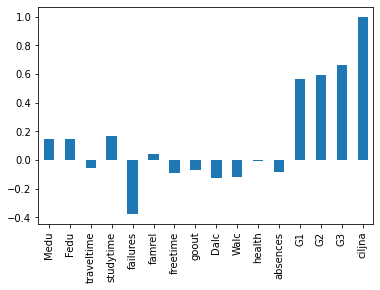

In [23]:
corrs_norm = df2[df2.columns[1:]].corr()['ciljna'][:]
corrs_norm.plot.bar();
corrs_norm

Ovom analizom želimo predvidjeti G3 (final grade) te otkriti korelaciju završne
ocjene s ostalim varijablama. Primjerice, utječe li konzumacija alkohola, broj izlazaka
s prijateljima, broj izostanaka ili zdravlje na finalne rezultate?

Druga zanimljiva pitanja su utječe li vrijeme putovanja do škole, romantična
veza ili odnos sa članovima obitelji na broj izostanaka?

Pogledajmo heatmap korelacijske matrice:

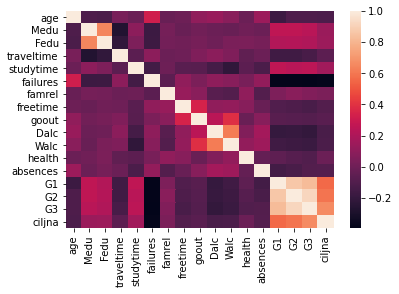

In [26]:
corr = df_norm.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns); #,vmin=-1,vmax=1)

te scatter matrix:

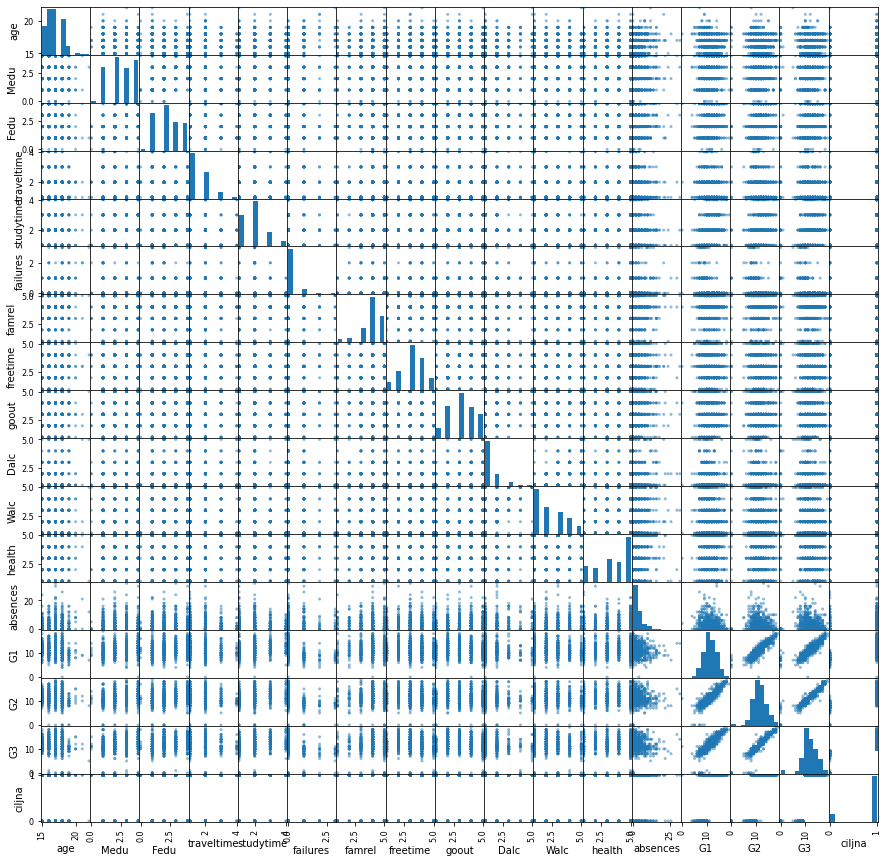

In [27]:
scatter_matrix(df, figsize=(15, 15));

Iz grafova jasno vidimo negativnu korelaciju failures (padova) s ocjenama po razredima (G1, G2, G3), a ako zasebno proučimo grafove odnosa prošlih ocjena i finalnog rezultata:

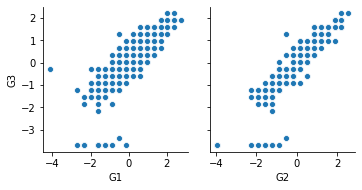

In [28]:
sns.pairplot(df_norm, x_vars=["G1", "G2"], y_vars=["G3"]);

možemo potvrditi snažnu korelaciju između prošlih rezultata i završne ocjene.

Također vidimo i korelaciju stupnja edukacije oca i majke, te vremena učenja, s finalnom ocjenom:

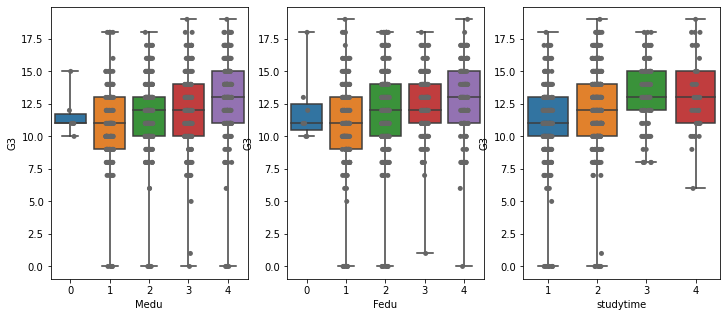

In [29]:
f, axes = plt.subplots(1,3, figsize=(12,5))
sns.boxplot(x="Medu", y="G3", data=df, whis=np.inf, ax=axes[0]);
sns.stripplot(x="Medu", y="G3", data=df, color=".4", ax=axes[0]);
sns.boxplot(x="Fedu", y="G3", data=df, whis=np.inf, ax=axes[1]);
sns.stripplot(x="Fedu", y="G3", data=df, color=".4", ax=axes[1]);
sns.boxplot(x="studytime", y="G3", data=df, whis=np.inf, ax=axes[2]);
sns.stripplot(x="studytime", y="G3", data=df, color=".4", ax=axes[2]);

Vrijeme učenja pobliže:

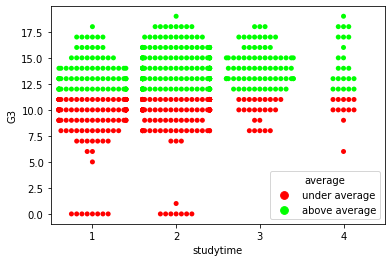

In [35]:
dftmp = df.copy()
ave = sum(dftmp.G3)/float(len(dftmp))
dftmp['ave_line'] = ave
dftmp['average'] = ['above average' if i > ave else 'under average' for i in dftmp.G3]
sns.swarmplot(x='studytime', y = 'G3', hue = 'average',data= dftmp,
              palette={'above average':'lime', 'under average': 'red'});
del(dftmp)

Jasno vidimo kako je u slučaju učenja vise jednako bolje, gdje je 5 - 10 sati
učenja zlatna sredina (sjetimo se da 3 za study time predstavlja 5 - 10 sati
učenja, a 4 - 10 ili vise sati).

Promotrimo dalje odnos izostanaka i toga jeli je student platio dodatne satove
u odnosu na finalnu ocjenu i ciljnu varijablu:

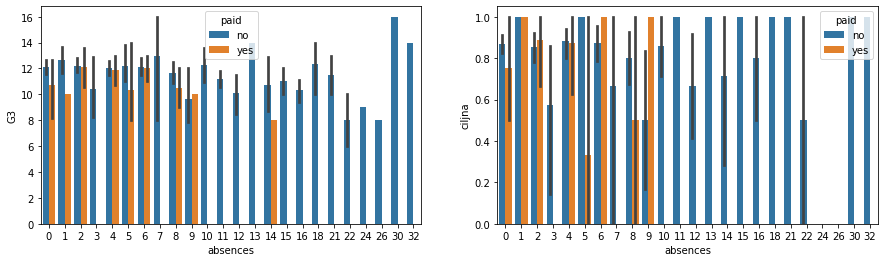

In [36]:
f, axes = plt.subplots(1,2, figsize=(15,4))
sns.barplot('absences', 'G3', hue='paid', data = df, ax=axes[0]);
sns.barplot('absences', 'ciljna', hue='paid', data = df, ax=axes[1]);

Jasno vidimo kako studenti koji plaćaju dodatne satove u pravilu izostaju rjeđe i
imaju nešto visu završnu ocjenu.

## IV, WoE izracuni

Pomoćne funkcije:

In [37]:
max_bin = 20
force_bin = 3

def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    woe = pd.DataFrame({'WOE':iv_df.groupby('VAR_NAME').IV.max()})
  
    return(iv_df,iv, woe) 

Izračun IV i WoE za svaku varijablu i grafički prikaz za WoE:

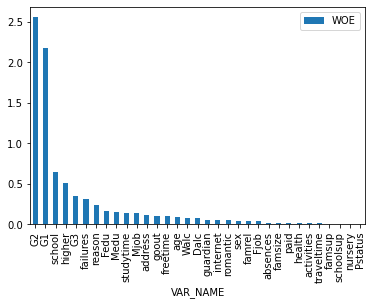

In [38]:
final_iv, IV, WOE = data_vars(df,df.ciljna)
WOE.sort_values('WOE', ascending=False).plot(kind='bar');

Najveći IV:

In [39]:
IV.sort_values('IV', ascending=False).head(10)

,VAR_NAME,IV
4,G2,2.558028
3,G1,2.183880
28,school,0.651013
22,higher,0.515254
5,G3,0.351222
14,failures,0.312183
26,reason,0.235301
1,Fedu,0.162264
6,Medu,0.151555
31,studytime,0.143612


Temeljem ove analize došli smo do nekoliko zaključaka:
- Ocjene predzadnje i pretpredzadnje godine jasno pokazuju kakva će biti ocjena zadnje godine.
Ako je učenik dvije godine za redom prošao, proći će i treće godine. Vrijedi i obrnuto,
učenik koji je jednom pao pasti će opet ili imati nizu završnu ocjenu. Ovo je najači pokazatelj.
- Zelja za nastavkom školovanja i visom edukacijom ima snažan utjecaj na prolazak i visinu završne ocjene,
sto je za očekivati jer ako učenik želi studirati dalje potruditi će se proći sto bolje sada.
- Učenici koji su odabrali školu zbog njene reputacije i predmeta imaju nešto bolji uspjeh
- Visoka edukacija majke i oca se pokazala također značajnom za ocjene učenika. Djeca visoko
educiranih roditelja imaju u pravilu bolje ocjene. To je možda povezano s velikim brojem roditelja
koji su profesori po zanimanju, njih čak 108!
- Sto se tiče učenja, vise je bolje. Optimalno je 5-10 sati uđenja tjedno, no i vise od 10 je dobro.
- Učenici koji su platili dodatne satove su manje izostajali i imali vise ocjene. Veći broj izostanaka je povezan sa nižim ocjenama.  Osobe u romantičnoj vezi izostaju nešto česce.
- Broj izlazaka i konzumacija alkohola nisu pretjerano bitni za ocjene dok god su umjereni.

Nas idealni učenik:
- ima dobre ocjene godinu za godinom
- uči vise od 5 sati
- roditelji su mu visokoobrazovani
- samac je i ne pije kroz tjedan

Nas rizični učenik:
- kontinuirano ima lose ocjene
- često izostaje
- uči manje od 2 sata tjedno
- pije neumjereno i/ili radim danima

## Logistička regresija

Želimo predviđati hoće li učenik imati pozitivnu ocjenu na temelju informacija koje imamo o njemu. Kako bi to postigli napraviti ćemo prediktivni model.

Pripremimo podatke enkodiranjem u binarne vrijednosti:

In [40]:
le = preprocessing.LabelEncoder()
cols = df.columns[df.dtypes==object].tolist()
for col in cols:
    n = len(df[col].unique())
    if (n == 2):
        df[col] = pd.get_dummies(df[col], drop_first=True)
df_d = pd.get_dummies(df)
df_d.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,18,1,0,0,4,4,2,2,...,0,0,1,1,0,0,0,0,1,0
1,0,0,17,1,0,1,1,1,1,2,...,1,0,0,1,0,0,0,1,0,0
2,0,0,15,1,1,1,1,1,1,2,...,1,0,0,0,0,1,0,0,1,0
3,0,0,15,1,0,1,4,2,1,3,...,0,1,0,0,1,0,0,0,1,0
4,0,0,16,1,0,1,3,3,1,2,...,1,0,0,0,1,0,0,1,0,0


Pogledajmo nove korelacije:

In [41]:
new_corr=df_d.corr()
new_corr['G3'].sort_values(ascending=False).head(10)

G3                   1.000000
G2                   0.918548
G1                   0.826387
ciljna               0.663157
higher               0.332172
studytime            0.249789
Medu                 0.240151
Fedu                 0.211800
reason_reputation    0.170944
address              0.167637
Name: G3, dtype: float64

Zanimaju nas samo najbitinije znacajke, pa cemo maknuti one koje imaju maleni utjecaj na finalnu ocjenu:

In [42]:
df_d=df_d.drop(['G3','failures','school','Dalc','Walc','Mjob_at_home','reason_other','sex','traveltime','freetime','age', 'health','reason_course', 'absences', 'romantic', 'goout', 'nursery', 'Pstatus', 'guardian_mother', 'Fjob_other', 'Fjob_at_home', 'Fjob_services', 'paid', 'Mjob_other', 'schoolsup', 'guardian_other'],axis=1)
df_d.head()

,address,famsize,Medu,Fedu,studytime,famsup,activities,higher,internet,famrel,...,G2,ciljna,Mjob_health,Mjob_services,Mjob_teacher,Fjob_health,Fjob_teacher,reason_home,reason_reputation,guardian_father
0,1,0,4,4,2,0,0,1,0,4,...,11,1,0,0,0,0,1,0,0,0
1,1,0,1,1,2,1,0,1,1,5,...,11,1,0,0,0,0,0,0,0,1
2,1,1,1,1,2,0,0,1,1,4,...,13,1,0,0,0,0,0,0,0,0
3,1,0,4,2,3,1,1,1,1,3,...,14,1,1,0,0,0,0,1,0,0
4,1,0,3,3,2,1,0,1,0,4,...,13,1,0,0,0,0,0,1,0,1


Dalje moramo podjeliti podatke na one za treniranje modela i one za testiranje, uzeti cemo omjer 80/20:

In [43]:
y=df_d.ciljna
x=df_d.drop('ciljna',axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)
print("train:",len(x_train),"test:",len(x_test))

train: 519 test: 130


Sada kada imamo podatke za treniranje primjeniti cemo algoritam za logisticku regresiju i provjeriti tocnost modela:

In [44]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
predictions = lr.predict(x_test)
cm = confusion_matrix(y_test, predictions)
print("Preciznost modela:", accuracy_score(y_test,predictions)*100)

Preciznost modela: 92.3076923076923


Model cemo spremiti u datoteku kako bi ga mogli kasnije ponovo iskoristiti za procjene:

In [45]:
joblib.dump(lr, 'model.pkl')

['model.pkl']

Testirajmo:

In [46]:
model = joblib.load(open('model.pkl', 'rb'))

data = {"address":"1","famsize":"0","Medu":"4","Fedu":"4","studytime":"2","famsup":"0","activities":"1","higher":"1","internet":"1","famrel":"3","G1":"17","G2":"18","Mjob_health":"0","Mjob_services":"0","Mjob_teacher":"1","Fjob_health":"0","Fjob_teacher":"1","reason_home":"1","reason_reputation":"0","guardian_father":"1"}
int_features = [int(value) for key, value in data.items()]
int_features
final_features = [np.array(int_features)]
prediction = model.predict(final_features)
print ("Pozitivna zavrsna ocjena." if prediction else "Negativna zavrsna ocjena.")

Pozitivna zavrsna ocjena.


## Aplikacija
Naposljetku želimo primijenitiprediktivni model u web aplikaciji u koju korisnik može unijeti podatke i dobiti procjenu.

Pokrenimo aplikaciju:

In [51]:
from multiprocessing import Process, Queue
from flask import Flask, request
import joblib

app = Flask(__name__)
model = joblib.load(open('model.pkl', 'rb'))

@app.route("/", methods = ['GET', 'POST'])
def index():
    if request.method == 'POST':
        data = request.get_json(force=True)
        int_features = [int(value) for key, value in data.items()]
        int_features
        final_features = [np.array(int_features)]
        prediction = model.predict(final_features)
        return "Pozitivna zavrsna ocjena." if prediction else "Negativna zavrsna ocjena."
    return "Hello, word!"

def start_app():
    app.config["ENV"] = "development"
    app.run(host='0.0.0.0', port=5005, debug=False)

queue = Queue()
server = Process(target=start_app)
server.start()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: development
 * Debug mode: off


 * Running on http://0.0.0.0:5005/ (Press CTRL+C to quit)
127.0.0.1 - - [09/Jun/2020 22:44:46] "POST / HTTP/1.1" 200 -


Posto nismo implementirali GUI sucelje aplikaciji cemo poslati nase podatke i dobiti odgovor pomocu curl komande:

In [52]:
!curl -d '{"address":"1","famsize":"0","Medu":"4","Fedu":"4","studytime":"2","famsup":"0","activities":"1","higher":"1","internet":"1","famrel":"3","G1":"17","G2":"18","Mjob_health":"0","Mjob_services":"0","Mjob_teacher":"1","Fjob_health":"0","Fjob_teacher":"1","reason_home":"1","reason_reputation":"0","guardian_father":"1"}' 0.0.0.0:5005

Pozitivna zavrsna ocjena.

Ukoliko nemamo curl instaliran ili dostupan isto mozemo napraviti i pomocu pythona:

In [49]:
import requests

data = {"address":"1","famsize":"0","Medu":"4","Fedu":"4","studytime":"2","famsup":"0","activities":"1","higher":"1","internet":"1","famrel":"3","G1":"17","G2":"18","Mjob_health":"0","Mjob_services":"0","Mjob_teacher":"1","Fjob_health":"0","Fjob_teacher":"1","reason_home":"1","reason_reputation":"0","guardian_father":"1"}
requests.post('http://0.0.0.0:5005', json=data).text

'Pozitivna zavrsna ocjena.'

Naposlijetku zelimo ugasiti flask server.

In [53]:
server.terminate()

## Zaključak
Proučavanje i analiziranje podataka je kompleksna i duboka tema. Kvalitetni, dobro strukturirani podatci su temelj za rad  nad podatcima. Računanje raznoraznih vrijednosti te izrada predikcijskih modela je olakšano brojnim funkcijama, bibliotekama i alatima koji su nam dostupni, no kako bi u potpunosti razumjeli podatke i rezultate, te uopće znali primijeniti gotova rješenja, moramo poznavati njihove interne procese i algoritme.

## Literatura
- Goran Klepac, Sustavi potpore odlucivanju
- Visualizing the distribution of a dataset, [Seaborn](https://seaborn.pydata.org/tutorial/distributions.html)
- Visualizing statistical relationships, [Seaborn](http://seaborn.pydata.org/tutorial/relational.html)
- Visualisation, [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)
- Exploring Distributions with Pandas and Seaborn, [Introduction to Data Science](https://sphinx-dat.readthedocs.io/en/latest/02-01-exploring-distributions.html)
- What are examples of discrete variables and continuous variables? [Quora](https://www.quora.com/What-are-examples-of-discrete-variables-and-continuous-variables)
- When should we discretize/bin continuous independent variables/features and when should not?, [Cross Validated](https://stats.stackexchange.com/questions/230750/when-should-we-discretize-bin-continuous-independent-variables-features-and-when)
- How to Compare Two Distributions in Practice *, [Medium](https://towardsdatascience.com/how-to-compare-two-distributions-in-practice-8c676904a285)
- Statistical Topics, [Yale](http://www.stat.yale.edu/Courses/1997-98/101/stat101.htm)
- Replacing Variables by WoE (Weight of Evidence) in Logistic Regression, [Cross Validated](https://stats.stackexchange.com/questions/189568/replacing-variables-by-woe-weight-of-evidence-in-logistic-regression)
- Why do we calculate Information value?, [Cross Validated](https://stats.stackexchange.com/questions/93170/why-do-we-calculate-information-value)
-  Weight of Evidence (WOE) and Information Value (IV) Explained, [Listen Data](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html)
- Weight of evidence and Information Value using Python, [Medium](https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb)
- IV + WoE Starter for Python, [kaggle](https://www.kaggle.com/puremath86/iv-woe-starter-for-python)
- P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.